# Practical machine learning and deep learning. Lab 14

# Time Series Forecasting

# [Competition](https://www.kaggle.com/t/2c1317d071d0417b940034efeb3ecead)

## Goal

Your goal is to implement the model that predicts the stock prices using rolling window.

## tsfresh

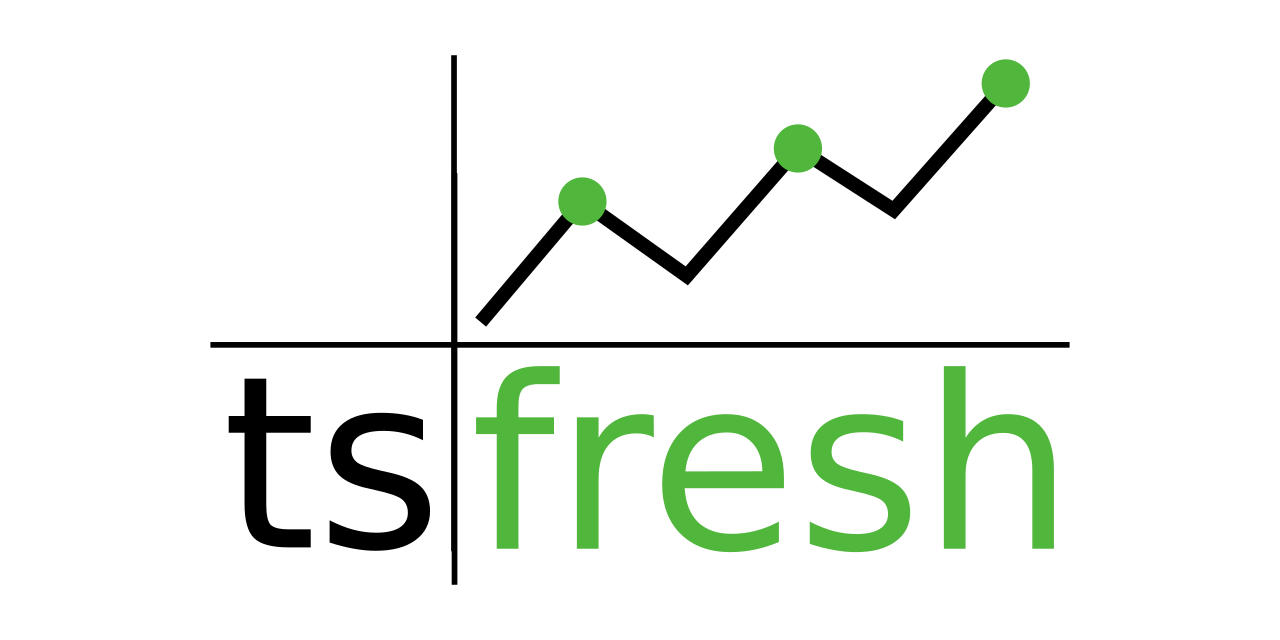

The tsfresh Python library is a tool for automated feature extraction from time series data. It is designed to help users extract a large number of features from time series datasets, which can then be used for various machine learning tasks such as classification, regression, and clustering. The library is particularly useful when dealing with time series data that may have complex patterns and relationships that are not immediately obvious.

Let us install the tsfresh and its dependencies:

In [1]:
!pip install tsfresh
!pip install dask[dataframe]

## Data Loading and Preparing

Import pandas and numpy to load and prepare the data:

In [2]:
import pandas as pd
import numpy as np

Load the training data:

In [3]:
df = pd.read_csv('/kaggle/input/pmldl-week-14-time-series-forecasting/train.csv')
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Price
0,2019-11-29,115.890
1,2019-12-02,114.563
2,2019-12-03,113.870
3,2019-12-04,113.773
4,2019-12-05,113.704
...,...,...
773,2022-12-23,141.650
774,2022-12-27,142.420
775,2022-12-28,140.020
776,2022-12-29,141.060


Now we create an `id` column. Later it will be clear why we do it. But, generally, tsfresh will use this column do distinguish various windows with values:

In [4]:
df["id"] = 'id'
df

,Date,Price,id
0,2019-11-29,115.890,id
1,2019-12-02,114.563,id
2,2019-12-03,113.870,id
3,2019-12-04,113.773,id
4,2019-12-05,113.704,id
...,...,...,...
773,2022-12-23,141.650,id
774,2022-12-27,142.420,id
775,2022-12-28,140.020,id
776,2022-12-29,141.060,id


## Visualizing Time Series

Take a look at the series:

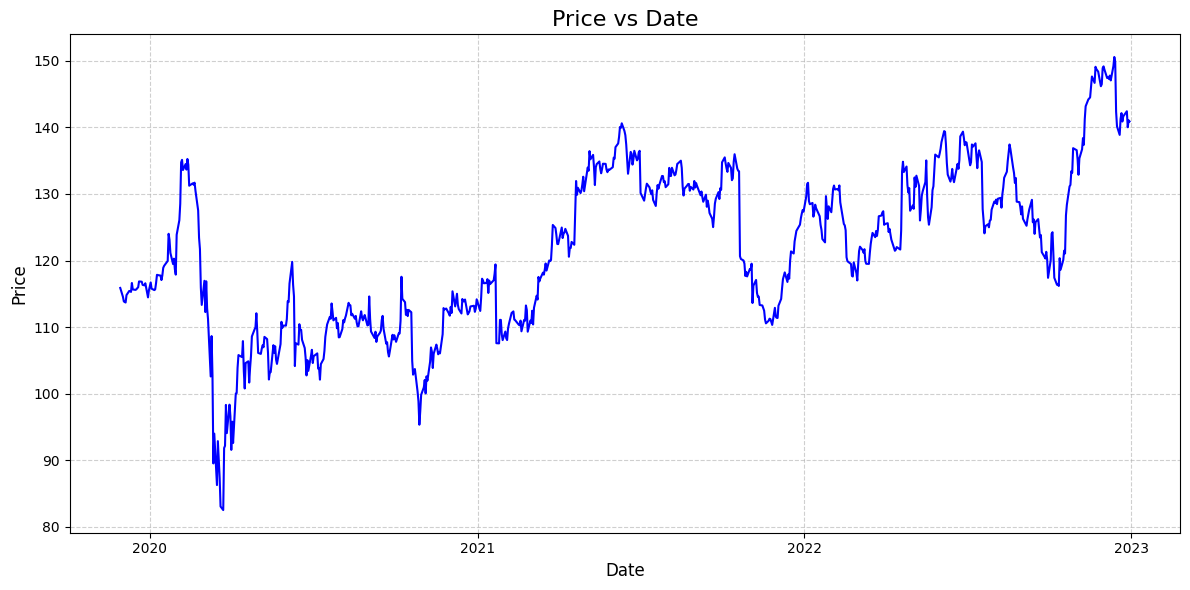

In [5]:
import matplotlib.pyplot as plt

# Plotting the Price vs Date
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], color='blue')

# Setting ticks at yearly intervals
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

# Adding titles and labels
plt.title('Price vs Date', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

## Time Series Rolling

Now we need to create the training samples from the series. It can be done by taking the values from the series within a certain window of a specified size. The values from the window will be used to predict the next values that go after the window.

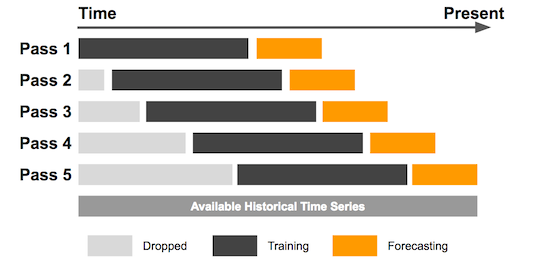

This rolling can be done with `roll_time_series` from tsfresh. [Here](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) is the description of how it works.

In [6]:
from tsfresh.utilities.dataframe_functions import roll_time_series

# Set the window size
window_size = 100

# Roll the time series with roll_time_series
df_rolled = roll_time_series(df, column_id="id", column_sort="Date", max_timeshift=window_size)

/opt/conda/lib/python3.10/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 10/10 [00:01<00:00,  9.10it/s]


Let's see what we've got:

In [7]:
df_rolled

,Date,Price,id
7625,2019-11-29,115.890,"(id, 2019-11-29 00:00:00)"
7626,2019-11-29,115.890,"(id, 2019-12-02 00:00:00)"
7627,2019-12-02,114.563,"(id, 2019-12-02 00:00:00)"
7628,2019-11-29,115.890,"(id, 2019-12-03 00:00:00)"
7629,2019-12-02,114.563,"(id, 2019-12-03 00:00:00)"
...,...,...,...
73523,2022-12-23,141.650,"(id, 2022-12-30 00:00:00)"
73524,2022-12-27,142.420,"(id, 2022-12-30 00:00:00)"
73525,2022-12-28,140.020,"(id, 2022-12-30 00:00:00)"
73526,2022-12-29,141.060,"(id, 2022-12-30 00:00:00)"


`id` is used to indicate rows that belong to the same window

In [8]:
df_rolled[df_rolled["id"] == ("id", pd.to_datetime("2022-12-30"))]

,Date,Price,id
73427,2022-08-09,127.945,"(id, 2022-12-30 00:00:00)"
73428,2022-08-10,129.951,"(id, 2022-12-30 00:00:00)"
73429,2022-08-11,130.978,"(id, 2022-12-30 00:00:00)"
73430,2022-08-12,132.431,"(id, 2022-12-30 00:00:00)"
73431,2022-08-15,133.340,"(id, 2022-12-30 00:00:00)"
...,...,...,...
73523,2022-12-23,141.650,"(id, 2022-12-30 00:00:00)"
73524,2022-12-27,142.420,"(id, 2022-12-30 00:00:00)"
73525,2022-12-28,140.020,"(id, 2022-12-30 00:00:00)"
73526,2022-12-29,141.060,"(id, 2022-12-30 00:00:00)"


## Features Extraction

Now, after we sampled the values for different windows we can create predicting features.

The features can be created with `extract_features`. Basically, it takes the samples from the window and calculates various statistics and indicator variables from the samples. These features include `sum_values`, `abs_energy`, `mean_abs_change`, `mean_second_derivative_central`, etc. In total, it creates 783 features.

The documentation for `extract_features` is [here](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#module-tsfresh.feature_extraction.extraction).

In [9]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Create feature with extract_features
X = extract_features(df_rolled, column_id="id", column_sort="Date", column_value="Price")
X = impute(X)

Feature Extraction: 100%|██████████| 10/10 [01:00<00:00,  6.02s/it]


Take a look at what features has been created:

In [10]:
X

Price__variance_larger_than_standard_deviation  \
id 2019-11-29                                             0.0   
   2019-12-02                                             0.0   
   2019-12-03                                             0.0   
   2019-12-04                                             0.0   
   2019-12-05                                             0.0   
...                                                       ...   
   2022-12-23                                             1.0   
   2022-12-27                                             1.0   
   2022-12-28                                             1.0   
   2022-12-29                                             1.0   
   2022-12-30                                             1.0   

               Price__has_duplicate_max  Price__has_duplicate_min  \
id 2019-11-29                       0.0                       0.0   
   2019-12-02                       0.0                       0.0   
   2019-12-03                       0.0                       0.0   
   2019-12-04                       0.0                       0.0   
   2019-12-05                       0.0                       0.0   
...                                 ...                       ...   
   2022-12-23                       0.0                       0.0   
   2022-12-27                       0.0                       0.0   
   2022-12-28                       0.0                       0.0   
   2022-12-29                       0.0                       0.0   
   2022-12-30                       0.0                       0.0   

               Price__has_duplicate  Price__sum_values  Price__abs_energy  \
id 2019-11-29                   0.0            115.890       1.343049e+04   
   2019-12-02                   0.0            230.453       2.655517e+04   
   2019-12-03                   0.0            344.323       3.952155e+04   
   2019-12-04                   0.0            458.096       5.246585e+04   
   2019-12-05                   0.0            571.800       6.539445e+04   
...                             ...                ...                ...   
   2022-12-23                   0.0          13455.676       1.802525e+06   
   2022-12-27                   0.0          13468.943       1.806128e+06   
   2022-12-28                   0.0          13480.493       1.809229e+06   
   2022-12-29                   0.0          13492.263       1.812411e+06   
   2022-12-30                   0.0          13503.736       1.815512e+06   

               Price__mean_abs_change  Price__mean_change  \
id 2019-11-29                1.359982            0.034550   
   2019-12-02                1.327000           -1.327000   
   2019-12-03                1.010000           -1.010000   
   2019-12-04                0.705667           -0.705667   
   2019-12-05                0.546500           -0.546500   
...                               ...                 ...   
   2022-12-23                1.466830            0.124970   
   2022-12-27                1.467700            0.139500   
   2022-12-28                1.483500            0.107300   
   2022-12-29                1.492630            0.116430   
   2022-12-30                1.479610            0.129450   

               Price__mean_second_derivative_central  Price__median  ...  \
id 2019-11-29                               0.001725       115.8900  ...   
   2019-12-02                               0.001725       115.2265  ...   
   2019-12-03                               0.317000       114.5630  ...   
   2019-12-04                               0.307500       114.2165  ...   
   2019-12-05                               0.209667       113.8700  ...   
...                                              ...            ...  ...   
   2022-12-23                               0.007338       132.4010  ...   
   2022-12-27                              -0.000253       132.4310  ...   
   2022-12-28                              -0.012763       132.

Notice, that the features dataframe has a complex index. We don't need it, so we get rid of `id` index and leave `Date` as the index.

In [11]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "Date"
X.head()

,Price__variance_larger_than_standard_deviation,Price__has_duplicate_max,Price__has_duplicate_min,Price__has_duplicate,Price__sum_values,Price__abs_energy,Price__mean_abs_change,Price__mean_change,Price__mean_second_derivative_central,Price__median,...,Price__fourier_entropy__bins_5,Price__fourier_entropy__bins_10,Price__fourier_entropy__bins_100,Price__permutation_entropy__dimension_3__tau_1,Price__permutation_entropy__dimension_4__tau_1,Price__permutation_entropy__dimension_5__tau_1,Price__permutation_entropy__dimension_6__tau_1,Price__permutation_entropy__dimension_7__tau_1,Price__query_similarity_count__query_None__threshold_0.0,Price__mean_n_absolute_max__number_of_maxima_7
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-29,0.0,0.0,0.0,0.0,115.890,13430.492100,1.359982,0.034550,0.001725,115.8900,...,0.297586,0.451359,1.220334,1.730887,2.868957,3.77872,4.302507,4.480914,0.0,134.465143
2019-12-02,0.0,0.0,0.0,0.0,230.453,26555.173069,1.327000,-1.327000,0.001725,115.2265,...,-0.000000,-0.000000,-0.000000,1.730887,2.868957,3.77872,4.302507,4.480914,0.0,134.465143
2019-12-03,0.0,0.0,0.0,0.0,344.323,39521.549969,1.010000,-1.010000,0.317000,114.5630,...,0.693147,0.693147,0.693147,-0.000000,2.868957,3.77872,4.302507,4.480914,0.0,134.465143
2019-12-04,0.0,0.0,0.0,0.0,458.096,52465.845498,0.705667,-0.705667,0.307500,114.2165,...,0.636514,1.098612,1.098612,-0.000000,-0.000000,3.77872,4.302507,4.480914,0.0,134.465143
2019-12-05,0.0,0.0,0.0,0.0,571.800,65394.445114,0.546500,-0.546500,0.209667,113.8700,...,0.636514,0.636514,1.098612,-0.000000,-0.000000,-0.00000,4.302507,4.480914,0.0,134.465143


Create target

In [12]:
# Shift the prices one position back to make the model predict the future values
y = df['Price'].shift(-1)

# Set the index to be the dates from the df dataframe
y.index = df['Date']

# We have made some rolling. So, some values from df will not be available in X.
# That's why we need to drop all row from y so that do not exist in X.
y = y.loc[X.index]
y

Date
2019-11-29    114.563
2019-12-02    113.870
2019-12-03    113.773
2019-12-04    113.704
2019-12-05    114.817
               ...   
2022-12-23    142.420
2022-12-27    140.020
2022-12-28    141.060
2022-12-29    140.890
2022-12-30        NaN
Name: Price, Length: 778, dtype: float64

Notice that the targets series do not have the last value now. We need to drop it from X and y.

In [13]:
# Save the index of the last value in y
last_date = y.index[-1]

# Drop nan values in y
y = y.dropna()
y

Date
2019-11-29    114.563
2019-12-02    113.870
2019-12-03    113.773
2019-12-04    113.704
2019-12-05    114.817
               ...   
2022-12-22    141.650
2022-12-23    142.420
2022-12-27    140.020
2022-12-28    141.060
2022-12-29    140.890
Name: Price, Length: 777, dtype: float64

Let's do the same for X:

In [14]:
# Drop the last index in X
X = X.iloc[:-1]
X

,Price__variance_larger_than_standard_deviation,Price__has_duplicate_max,Price__has_duplicate_min,Price__has_duplicate,Price__sum_values,Price__abs_energy,Price__mean_abs_change,Price__mean_change,Price__mean_second_derivative_central,Price__median,...,Price__fourier_entropy__bins_5,Price__fourier_entropy__bins_10,Price__fourier_entropy__bins_100,Price__permutation_entropy__dimension_3__tau_1,Price__permutation_entropy__dimension_4__tau_1,Price__permutation_entropy__dimension_5__tau_1,Price__permutation_entropy__dimension_6__tau_1,Price__permutation_entropy__dimension_7__tau_1,Price__query_similarity_count__query_None__threshold_0.0,Price__mean_n_absolute_max__number_of_maxima_7
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-29,0.0,0.0,0.0,0.0,115.890,1.343049e+04,1.359982,0.034550,0.001725,115.8900,...,0.297586,0.451359,1.220334,1.730887,2.868957,3.778720,4.302507,4.480914,0.0,134.465143
2019-12-02,0.0,0.0,0.0,0.0,230.453,2.655517e+04,1.327000,-1.327000,0.001725,115.2265,...,-0.000000,-0.000000,-0.000000,1.730887,2.868957,3.778720,4.302507,4.480914,0.0,134.465143
2019-12-03,0.0,0.0,0.0,0.0,344.323,3.952155e+04,1.010000,-1.010000,0.317000,114.5630,...,0.693147,0.693147,0.693147,-0.000000,2.868957,3.778720,4.302507,4.480914,0.0,134.465143
2019-12-04,0.0,0.0,0.0,0.0,458.096,5.246585e+04,0.705667,-0.705667,0.307500,114.2165,...,0.636514,1.098612,1.098612,-0.000000,-0.000000,3.778720,4.302507,4.480914,0.0,134.465143
2019-12-05,0.0,0.0,0.0,0.0,571.800,6.539445e+04,0.546500,-0.546500,0.209667,113.8700,...,0.636514,0.636514,1.098612,-0.000000,-0.000000,-0.000000,4.302507,4.480914,0.0,134.465143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,1.0,0.0,0.0,0.0,13442.662,1.799007e+06,1.464300,0.122440,-0.008975,131.6600,...,0.192626,0.288342,0.651889,1.698101,2.755411,3.646979,4.097405,4.309380,0.0,149.364286
2022-12-23,1.0,0.0,0.0,0.0,13455.676,1.802525e+06,1.466830,0.124970,0.007338,132.4010,...,0.192626,0.288342,0.651889,1.701364,2.766796,3.666665,4.097405,4.309380,0.0,149.364286
2022-12-27,1.0,0.0,0.0,0.0,13468.943,1.806128e+06,1.467700,0.139500,-0.000253,132.4310,...,0.192626,0.288342,0.651889,1.692351,2.768505,3.652373,4.097405,4.309380,0.0,149.364286


## Modelling

We have got predictors and target. Now, we can train a regressor to predict the price:

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Display the first few predictions and actual values
results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})
print(results.head())

Mean Squared Error: 6.8181625419636545
             Actual   Predicted
Date                           
2022-03-03  122.087  120.518240
2022-01-06  128.460  128.292390
2022-05-03  132.481  129.269080
2020-05-07  108.542  105.570824
2022-03-29  127.407  126.573840


## Inference

In order to sequentially predict the values we need to write the function which takes the last `window_size` values, creates features and passes them to the model.

In [16]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

def predict_next_price(prev_values):
    prev_values = prev_values.sort_values("Date")
    prev_values['id'] = 'id'

    # Extract features from the rolling window
    features = extract_features(
        prev_values,
        column_id="id",
        column_sort="Date",
        column_value="Price",
        disable_progressbar=True
    )

    # Impute missing values in the features
    features = impute(features)

    # Use the trained regressor to predict the next price
    pred_value = regressor.predict(features)

    return pred_value[-1]

prev_values = df.sort_values('Date').tail(window_size)
predicted_price = predict_next_price(prev_values)
print(f"Predicted next price: {predicted_price}")

Predicted next price: 143.29159


Let us read the dates for which we need to predict prices:

In [17]:
df_test = pd.read_csv('/kaggle/input/pmldl-week-14-time-series-forecasting/test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test

,Date
0,2023-01-03
1,2023-01-04
2,2023-01-05
3,2023-01-06
4,2023-01-09
...,...
474,2024-11-20
475,2024-11-21
476,2024-11-22
477,2024-11-25


Predict the prices for the test dates

In [18]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

# Sort the DataFrame by the "Date" column and extract the sorted dates and prices into lists
dates = df.sort_values("Date").Date.tolist()
prices = df.sort_values("Date").Price.tolist()

# Initialize an empty list to store the predicted prices
predicted_prices = []

# Loop through each row in the test DataFrame, with a progress bar using tqdm
for i in tqdm(range(len(df_test))):
    # Create a DataFrame with the last 'window_size' dates and prices for prediction
    prev_values = pd.DataFrame({
        "Date": dates[-window_size:], 
        "Price": prices[-window_size:]
    })

    # Predict the next price using the features DataFrame
    next_price = predict_next_price(prev_values)

    # Append the test date to the dates list
    dates.append(df_test.iloc[i]["Date"])

    # Append the predicted price to the prices list
    prices.append(next_price)

    # Append the predicted price to the predicted_prices list
    predicted_prices.append(next_price)

# Display the predicted prices
print(predicted_prices)


100%|██████████| 479/479 [02:25<00:00,  3.29it/s]

[143.29159, 143.22614000000004, 143.16478000000006, 143.1221500000001, 143.42906000000005, 143.22566000000006, 143.36463000000003, 143.40321000000006, 143.15522000000007, 142.96176000000003, 142.85944000000003, 142.87757000000008, 142.60702000000003, 142.24093000000005, 142.25552000000005, 142.44048000000006, 143.11342000000002, 143.03454000000002, 143.15930000000006, 143.09632, 143.1976, 143.33558000000005, 143.55479000000005, 143.70687000000004, 143.55596000000003, 144.03579000000005, 144.1688000000001, 144.26403000000002, 144.2298000000001, 144.93875000000003, 144.68769000000003, 144.29481, 144.11416000000006, 144.37388000000007, 144.45937000000004, 144.38592000000003, 145.3035000000001, 144.94883000000004, 143.82637000000005, 137.58525000000003, 137.50560000000004, 137.40958, 137.11884000000003, 137.32765, 136.99643, 135.97119, 135.91177000000005, 135.66393, 135.33808, 135.01260000000005, 134.64805, 132.99902, 131.69875, 130.58794000000006, 125.36322000000007, 123.29493000000004, 1

Now let's visualize the predictions

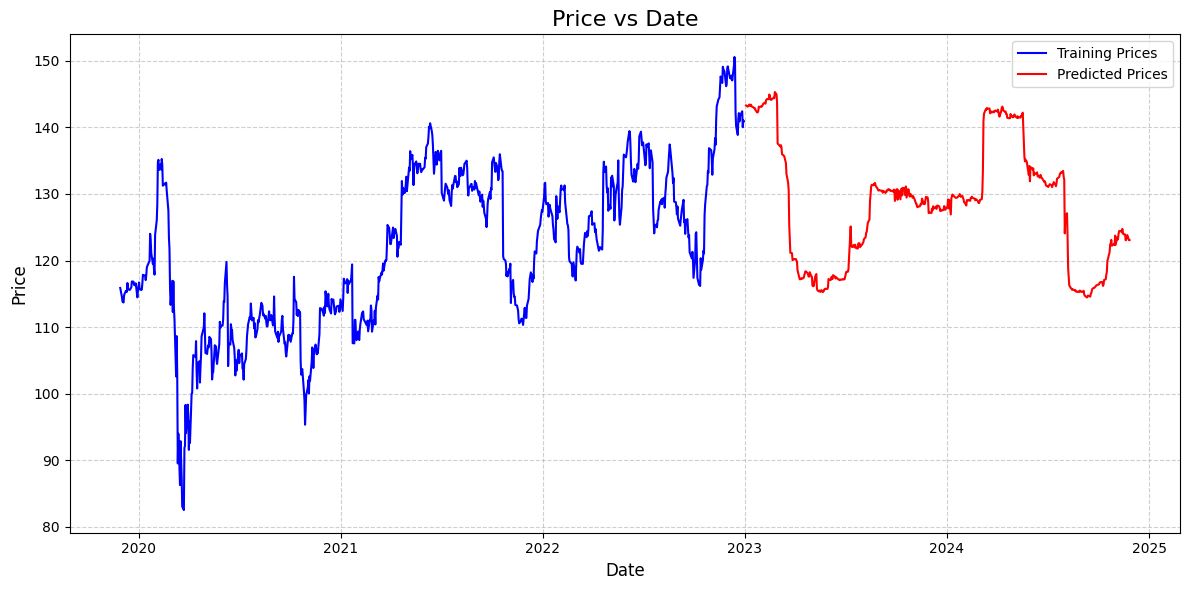

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], color='blue', label='Training Prices')
plt.plot(df_test['Date'], predicted_prices, color='red', label='Predicted Prices')

plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.title('Price vs Date', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Save the predictions in `submission.csv` file

In [20]:
df_submission = pd.DataFrame({
    'Date': df_test.Date,
    'Price': predicted_prices
})
df_submission.to_csv('submission.csv', index=False)

When participating in the competition you are not restricted to only the approach with rolling window. You are allowed to try other approaches such as ARIMA, RNN, Prophet. Try them to increase your score.

Good luck!